In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2026-01-03 02:20:14.031038: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-03 02:20:14.043172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767378014.057266    1790 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767378014.061325    1790 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-03 02:20:14.076404: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
IMG_FOLDER = '/mnt/f/course/computer_vision/final_proj_img/final_proj_img/pic/'
TXT_FOLDER = '/mnt/f/course/computer_vision/txt/'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [3]:
def load_dataset_from_name_txt(img_folder, txt_folder):
    filename_list = []
    class_name_list = []
    
    # 1. 讀取 name.txt
    # 格式: "AncestorDinoArt_001.jpg AncestorDinoArt"
    name_txt_path = os.path.join(txt_folder, 'name.txt')
    print(f"Reading name.txt from: {name_txt_path}")
    
    with open(name_txt_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                filename_list.append(parts[0])      # e.g., AncestorDinoArt_001.jpg
                class_name_list.append(parts[1])    # e.g., AncestorDinoArt (這也是資料夾名稱)
    
    # 2. 建立標籤對照表
    unique_classes = sorted(list(set(class_name_list)))
    class_to_idx = {name: i for i, name in enumerate(unique_classes)}
    print(f"Detected {len(unique_classes)} classes.")

    # 3. 讀取 query.txt (注意：這裡假設 query.txt 是 1-based index)
    query_txt_path = os.path.join(txt_folder, 'query.txt')
    with open(query_txt_path, 'r') as f:
        test_indices = set([int(line.strip()) - 1 for line in f])

    # 4. 分裝 Train / Test
    train_paths = []
    train_labels = []
    test_paths = []
    test_labels = []

    missing_count = 0

    for idx, filename in enumerate(filename_list):
        class_name = class_name_list[idx]
        
        # --- [關鍵修正] 路徑加入類別資料夾 ---
        # 舊路徑: pic/AncestorDinoArt_001.jpg (錯誤)
        # 新路徑: pic/AncestorDinoArt/AncestorDinoArt_001.jpg (正確)
        full_path = os.path.join(img_folder, class_name, filename)
        
        label_idx = class_to_idx[class_name]
        
        # 檢查檔案是否存在
        if not os.path.exists(full_path):
            if missing_count < 5: # 只印出前 5 個錯誤以免洗版
                print(f"Warning: File not found: {full_path}")
            missing_count += 1
            continue

        if idx in test_indices:
            test_paths.append(full_path)
            test_labels.append(label_idx)
        else:
            train_paths.append(full_path)
            train_labels.append(label_idx)

    if missing_count > 0:
        print(f"Total missing files: {missing_count}")
    else:
        print("All files found successfully!")

    return (train_paths, train_labels), (test_paths, test_labels), len(unique_classes)

# --- 執行讀取測試 ---
(tr_x, tr_y), (te_x, te_y), num_classes = load_dataset_from_name_txt(IMG_FOLDER, TXT_FOLDER)

print(f"Training Data: {len(tr_x)} images")
print(f"Testing Data: {len(te_x)} images")

# 建立 tf.data Pipeline
def preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    # 將標籤轉換為 one-hot 編碼
    label_onehot = tf.one_hot(label, depth=num_classes)
    return img, label_onehot

train_ds = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((te_x, te_y))
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Ready for ResNet/VGG training!")

Reading name.txt from: /mnt/f/course/computer_vision/txt/name.txt
Detected 50 classes.
Total missing files: 2
Training Data: 6999 images
Testing Data: 2999 images
Ready for ResNet/VGG training!


I0000 00:00:1767378037.381348    1790 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [4]:
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152, VGG16, VGG19
from tensorflow.keras import layers, models, Input

In [5]:
def build_model(model_name):
    inputs = Input(shape=(224, 224, 3))
    if model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    elif model_name == 'ResNet101':
        base_model = ResNet101(weights='imagenet', include_top=False, input_tensor=inputs)
    elif model_name == 'ResNet152':
        base_model = ResNet152(weights='imagenet', include_top=False, input_tensor=inputs)
    elif model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)
    elif model_name == 'VGG19':
        base_model = VGG19(weights='imagenet', include_top=False, input_tensor=inputs)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    base_model.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model


In [6]:
model_list = ['VGG16', 'VGG19', 'ResNet50', 'ResNet101', 'ResNet152']
history_dict = {}
results = {}
EPOCHS = 70

for model_name in model_list:
    print(f"Training {model_name}")
    model = build_model(model_name)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'precision', 'recall', 'f1_score', 'auc']
    )
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=test_ds,
        callbacks=callbacks
    )
    history_dict[model_name] = history.history
    
    eval_results = model.evaluate(test_ds)
    # eval_results = [loss, accuracy, precision, recall, f1_score, auc]
    acc = eval_results[1]
    results[model_name] = acc
    print(f"{model_name} Final Accuracy: {acc:.4f}")
    
    # 釋放記憶體
    del model
    tf.keras.backend.clear_session()

Training VGG16
Epoch 1/70


/home/guan/cuda_test/tf-venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1767378039.541448    1885 service.cc:148] XLA service 0x7dddf400ee70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767378039.541482    1885 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2026-01-03 02:20:39.594967: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1767378039.810386    1885 cuda_dnn.cc:529] Loaded cuDNN version 90300
2026-01-03 02:20:40.482749: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memor

  2/219 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.0391 - auc: 0.4007 - f1_score: 0.0014 - loss: 4.2434 - precision: 0.0000e+00 - recall: 0.0000e+00         

I0000 00:00:1767378052.392776    1885 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.0484 - auc: 0.4991 - f1_score: 0.0056 - loss: 4.4758 - precision: 0.0512 - recall: 0.0096

2026-01-03 02:21:14.681230: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1339', 32 bytes spill stores, 32 bytes spill loads

2026-01-03 02:21:14.714076: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1642', 32 bytes spill stores, 32 bytes spill loads

2026-01-03 02:21:14.797384: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1642', 32 bytes spill stores, 32 bytes spill loads

2026-01-03 02:21:14.814500: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1642', 24 bytes spill stores, 24 bytes spill loads

2026-01-03 02:21:16.393773: W external/local_xla/xla/tsl/fra

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.0482 - auc: 0.4987 - f1_score: 0.0056 - loss: 4.4750 - precision: 0.0511 - recall: 0.0096

2026-01-03 02:21:24.265636: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_292', 16 bytes spill stores, 16 bytes spill loads

2026-01-03 02:21:33.818151: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_292', 24 bytes spill stores, 24 bytes spill loads



219/219 ━━━━━━━━━━━━━━━━━━━━ 57s 194ms/step - accuracy: 0.0480 - auc: 0.4983 - f1_score: 0.0055 - loss: 4.4742 - precision: 0.0511 - recall: 0.0096 - val_accuracy: 0.0200 - val_auc: 0.5025 - val_f1_score: 7.9103e-04 - val_loss: 3.9105 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/70
219/219 ━━━━━━━━━━━━━━━━━━━━ 29s 130ms/step - accuracy: 0.0959 - auc: 0.5988 - f1_score: 0.0058 - loss: 3.8995 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0397 - val_auc: 0.5093 - val_f1_score: 0.0264 - val_loss: 3.9088 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/70
219/219 ━━━━━━━━━━━━━━━━━━━━ 29s 132ms/step - accuracy: 0.0964 - auc: 0.6834 - f1_score: 0.0156 - loss: 3.8239 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0547 - val_auc: 0.5228 - val_f1_score: 0.0369 - val_loss: 3.8990 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/70
219/219 ━━━━━━━━━━━━━━━━━━━━ 29s 132ms/step - accuracy: 0.0207 - auc: 0.6827 - f1_score: 0.0040

2026-01-03 03:29:28.322848: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5062_0', 112 bytes spill stores, 224 bytes spill loads

2026-01-03 03:29:28.354969: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5730', 68 bytes spill stores, 72 bytes spill loads

2026-01-03 03:29:28.458403: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5062', 220 bytes spill stores, 576 bytes spill loads

2026-01-03 03:29:28.492281: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5730', 60 bytes spill stores, 64 bytes spill loads

2026-01-03 03:29:28.496060: I external/local_xla/xla/s

218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.0674 - auc: 0.5524 - f1_score: 0.0084 - loss: 4.9190 - precision: 0.1199 - recall: 0.0455

2026-01-03 03:29:48.020965: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5062_0', 8 bytes spill stores, 8 bytes spill loads

2026-01-03 03:29:48.204214: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5730', 32 bytes spill stores, 32 bytes spill loads

2026-01-03 03:29:48.325645: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5062', 80 bytes spill stores, 80 bytes spill loads

2026-01-03 03:29:48.369804: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5730', 24 bytes spill stores, 24 bytes spill loads

2026-01-03 03:29:48.499512: I external/local_xla/xla/stream_

219/219 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - accuracy: 0.0670 - auc: 0.5517 - f1_score: 0.0083 - loss: 4.9148 - precision: 0.1197 - recall: 0.0451 - val_accuracy: 0.0200 - val_auc: 0.5001 - val_f1_score: 7.8534e-04 - val_loss: 3.9141 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/70
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.0955 - auc: 0.6471 - f1_score: 0.0031 - loss: 3.8734 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0200 - val_auc: 0.5002 - val_f1_score: 7.8534e-04 - val_loss: 3.9139 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/70
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.0955 - auc: 0.6446 - f1_score: 0.0031 - loss: 3.8748 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0200 - val_auc: 0.5002 - val_f1_score: 7.8534e-04 - val_loss: 3.9138 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/70
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.1028 - auc: 0.6442 - f1_score: 0

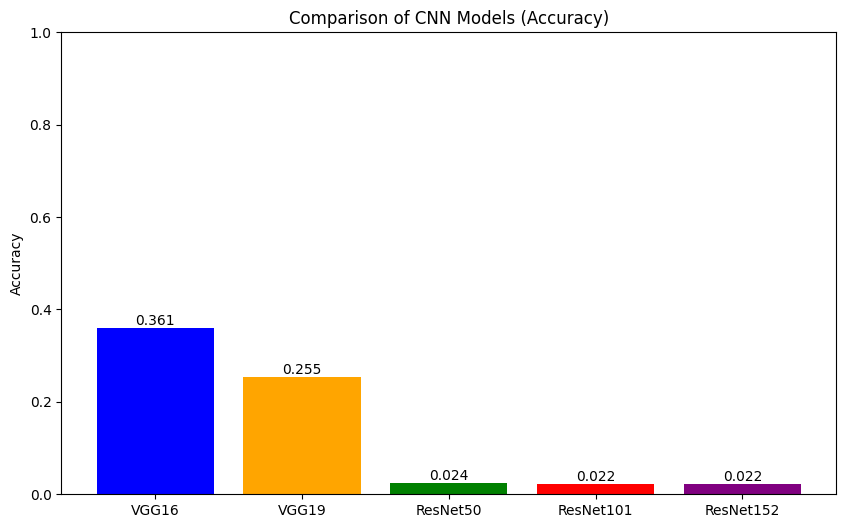

In [7]:
import matplotlib.pyplot as plt
# 繪製 Accuracy 比較長條圖
names = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(names, accuracies, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.ylim(0, 1.0)
plt.title('Comparison of CNN Models (Accuracy)')
plt.ylabel('Accuracy')

# 在長條圖上標示數值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

plt.show()